This notebook opens JWST files and plots the images as a panel figure.


In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
import sys, os
# !{sys.executable} -m pip install aplpy
import numpy as np
import aplpy
from astropy.table import Table

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Functions

# Function to CHECK IF RAS AND DECS ARE IN AN IMAGE
def check_in_image(SNras, SNdecs, SNnames, SNtypes, GalaxyImg):
    hdulist = pyfits.open(GalaxyImg)
    map = hdulist[1].data
    wcs = WCS(hdulist[1].header, naxis=0)
    #print(wcs._naxis)
    coords_arr = np.column_stack((SNras, SNdecs)) # ras and decs now [ra,dec]
    pix_x, pix_y = wcs.wcs_world2pix(SNras,SNdecs,0)

    #use world coordinates of all SNe to see if any fall in image (our version of footprint_contains)
    naxis = wcs._naxis #size of image
    naxis1 = hdulist[1].header['NAXIS1']
    naxis2 = hdulist[1].header['NAXIS2']
    is_in_x = (pix_x >= 0) & (pix_x <= naxis1-1) #because of 0-indexing
    is_in_y = (pix_y >= 0) & (pix_y <= naxis2-1)
        
    #get the name, ra, and dec of the SNe that fall in image
    #boolean array indexing (gives back array of Trues and Falses)
    #we are pulling out the SNe that are True and assigning them to own arrays
    name_in_image = np.array(SNnames)[is_in_x & is_in_y]
    type_in_image = np.array(SNtypes)[is_in_x & is_in_y]
    ra_in_image = np.array(SNras)[is_in_x & is_in_y]
    dec_in_image = np.array(SNdecs)[is_in_x & is_in_y]

    x_coord = np.array(pix_x)[is_in_x & is_in_y]
    y_coord = np.array(pix_y)[is_in_x & is_in_y]
    
    return (name_in_image, type_in_image, ra_in_image, dec_in_image, x_coord, y_coord, map, naxis1, naxis2)

In [3]:
# grab list of files

fileList = "/Users/nessmayker/Desktop/JWSTLargeFiles/ngc1365_lvl3_from_mast/filelist.txt"
fileNames = np.genfromtxt(fileList, dtype=str, unpack=True, usecols=(0))
fileNames = ["/Users/nessmayker/Desktop/JWSTLargeFiles/ngc1365_lvl3_from_mast/" + x for x in fileNames]

SN_Sample_File = '../Data/1.FullCatalog-11-5-22.csv'
data = Table.read(SN_Sample_File, format='csv')
# SN_Sample.add_row(['TEST', 'NGC1365', 53,36, 53.39486166666666, -36.14314722222224, 'TEST','TEST'])
#print(fileNames)

In [4]:
# set up plots & wcs information.
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
from astropy.wcs import WCS
plots, wcss, hdus, names, types, ras, decs, xs, ys, maps, nax1s, nax2s = [],[],[],[],[],[],[],[],[],[],[],[]

for i in range(len(fileNames)):
    if os.path.isfile(fileNames[i]):
        ns, ts, rs, ds, xcs, ycs, ms, n1s, n2s = check_in_image(data['RA dds'], data['Dec dds'], data['Name'], data['Type'], fileNames[i])
        names.append(ns)
        types.append(ts)
        ras.append(rs)
        decs.append(ds)
        xs.append(xcs)
        ys.append(ycs)
        maps.append(ms)
        nax1s.append(n1s)
        nax2s.append(n2s)
        JWST_hdu = pyfits.open(fileNames[i])
        hdus.append(JWST_hdu)
        JWST_map = JWST_hdu[1].data
        plots.append(JWST_map)
        wcss.append(WCS(JWST_hdu[1].header, naxis=2))

current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("black")


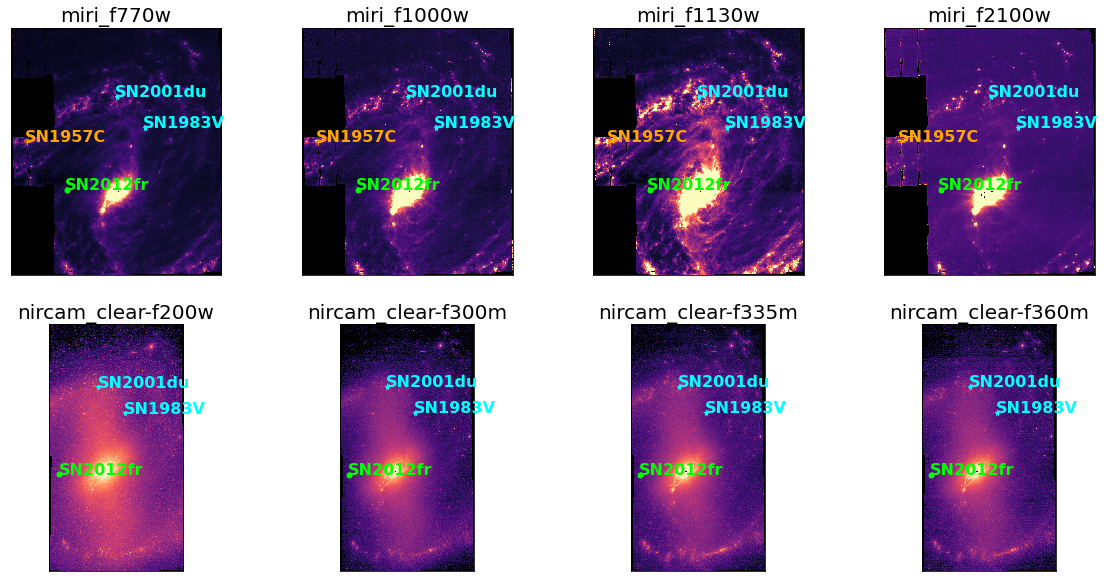

In [5]:
#        1,       2,      3,       4,        5,       6,       7,     8
vmm = [[5,125],[15,25],[22,35],[208,235],[0.1,40],[0.1,40],[0.1,40],[0.1,40]]
imgs = ["miri_f770w", "miri_f1000w", "miri_f1130w", "miri_f2100w",
        "nircam_clear-f200w", "nircam_clear-f300m", "nircam_clear-f335m",
        "nircam_clear-f360m"]

# make multipanel plot  
import math
i,j,m=0,0,0
PLOTS_PER_ROW = 4
fig, axs = plt.subplots(math.ceil(len(plots)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 10))

for plot in plots:
    logplot = np.log10(plot)
    axs[i][j].imshow(logplot, cmap=current_cmap, aspect="equal", 
                     origin = "lower", interpolation = "nearest",
                    vmin=np.log10(vmm[m][0]), vmax=np.log10(vmm[m][1]))
    axs[i][j].set_title(imgs[m], fontsize=20)
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])

    for k in range(len(names[m])):
        string = names[m][k]
        if (len(types[m][k])>1):
            if types[m][k][1] == "I":
                colorCode = 'cyan'
                mkr = '*'
            elif types[m][k][1] == "b" or types[m][k][1] == "c":
                colorCode = 'yellow'
                mkr = '^'
            elif types[m][k][1] == "a":
                colorCode = 'lime'
                mkr = 'o'
            else:
                colorCode = 'orange'
                mkr = '+'
        else:
            colorCode = 'pink'
            mkr='s'
            
        axs[i][j].plot(xs[m][k], ys[m][k], marker=mkr, ms=5, color=colorCode, zorder=10)
        axs[i][j].text(xs[m][k]-20, ys[m][k]+8, string, fontsize=16, fontweight='bold', color=colorCode)

    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
    m+=1
plt.show()
fig.savefig("../Figures/NGC1365allPanels.png", dpi=300)
plt.close()